In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token

In [4]:
text_root = '/Users/erickpeirson/EmbryoProjectTexts/files'
zotero_export_path = '/Users/erickpeirson/EmbryoProjectTexts'

corpus = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

# 1.3. Features in texts: N-grams

In earlier notebooks, we treated individual tokens as separate and independent features in our texts. But words are rarely independent. First of all, they are often part of more complex phrases that refer to abstract concepts. In the context of computational humanities, it is usually those abstract concepts and not individual words that we want to interrogate. A major component of our analytic workflow, therefore, will be deciding what kinds of features we are interested in, and developing strategies to extract those features.

## Phrases

Multi-word phrases are an easy place to start. Our objective is to identify sequences of tokens that belong together as a phrase. For example, in the sentence "The quick brown fox jumps over the lazy dog", we want to be able to extract phrases like "brown fox" and "lazy dog". We do this by looking for **N-grams** whose joint probability are high in comparison to the individual probabilities of their constituent tokens.

An **N-gram** is a sequence of **N** adjacent tokens. A **bigram** is a sequence of 2 adjacent tokens. For example, here are the first 7 tokens in our corpus:

In [13]:
corpus.words()[:7]

[u'By', u'Mandana', u'Minai', u'Published', u':', u'2016', u'-']

and here are the first 6 bigrams:

In [14]:
[gram for gram in nltk.bigrams(corpus.words())][:6]

[(u'By', u'Mandana'),
 (u'Mandana', u'Minai'),
 (u'Minai', u'Published'),
 (u'Published', u':'),
 (u':', u'2016'),
 (u'2016', u'-')]

and the first 5 trigrams:

In [11]:
[gram for gram in nltk.trigrams(corpus.words())][:5]

[(u'By', u'Mandana', u'Minai'),
 (u'Mandana', u'Minai', u'Published'),
 (u'Minai', u'Published', u':'),
 (u'Published', u':', u'2016'),
 (u':', u'2016', u'-')]

Our task is to decide which of these N-grams are actually phrases.

## Pointwise Mutual Information

Mutual Information is a measure of the mutual interdependence of two variables. Mutual information captures the extent to which knowing one variable reduces our uncertainty about another variable. **Pointwise Mutual Information** applies the concept of mutual information to specific events. PMI captures the likelihood that a specific event will occur given that another specific event was observed. To apply this to tokens in our corpus: the PMI of two tokens ($x$ and $y$) measures how likely it is that one specific token (say, $y$) will occur in a specific context (e.g. a bigram) given that another specific token (say, $x$) is observed in that context.

PMI is defined as:

$pmi(x; y) = \frac{p(x, y}{p(x)p(y)}$

The denominator in the equation above, $p(x)p(y)$, is the probability that $x$ and $y$ will occur together by chance alone given their independent distributions. The numerator, $p(x, y)$, is the probability of coincidence given their joint distribution. 

It makes a little more sense if you think about those probabilities in terms of frequency (recall that the MLE for $p(x)$ in our corpus is $f(x)$). If two tokens occur more often together than they do on their own, then chances are those tokens are related to each other.

NLTK provides some tools to find **colocations** using PMI.

In [29]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(corpus.words())

In [30]:
finder.nbest(bigram_measures.pmi, 10)

[(u'(-', u'CH3'),
 (u'(\xe4', u'usserer'),
 (u')(', u'qllql3'),
 (u').%', u'3C'),
 (u'.$', u'b522144'),
 (u'/#.', u'UmsuVxC7aYN'),
 (u'3C745', u'::'),
 (u':./', u'temp'),
 (u':\u201d', u'Eulogy'),
 (u'<!--/*--><![', u'CDATA')]

We end up with a lot of junk collocations. This is often due to very infrequent N-grams; consider a bigram with tokens that occur only once in the whole corpus: they will have a maximal PMI, since they don't occur independently. We can filter out infrequent N-grams using the ``apply_freq_filter()`` function.

In [35]:
finder.apply_freq_filter(3)
finder.nbest(bigram_measures.pmi, 10)

[(u'Actinien', u'anatomisch'),
 (u'Agalychnis', u'callidryas'),
 (u'Androulla', u'Economou'),
 (u'Astacus', u'astacus'),
 (u'Cusance', u'Morant'),
 (u'Exakten', u'Erblichkeitslehre'),
 (u'Expanding', u'Approved'),
 (u'Falske', u'Analogier'),
 (u'Geograficheskogo', u'obshchestva'),
 (u'Hathaitip', u'Sritanaudomchai')]

We can also apply our filter from earlier notebooks using the ``apply_word_filter()`` function. This function expects another function that will return ``True`` if a token should be excluded. Our ``filter_token()`` function does the opposite (``True`` to keep a token), so we can use a [lambda function](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) to invert it.

In [32]:
finder.apply_word_filter(lambda token: not filter_token(token))
finder.nbest(bigram_measures.pmi, 10)

[(u'AMPA', u'Conductances'),
 (u'Abbesha', u'Nadarajah'),
 (u'Abby', u'Lippman'),
 (u'Abruptio', u'Placentae'),
 (u'Academischen', u'Buchdrukerei'),
 (u'Acetone', u'evaporates'),
 (u'Acraea', u'encedon'),
 (u'Active', u'Citizenry'),
 (u'Acute', u'Fluorosis'),
 (u'Acyrthosiphon', u'pisum')]

Depending on what kind of phrases you are interested in, it may be desirable to filter N-grams based on the part of speach (POS) of their constituent tokens. The ``pos_tag()`` function generates a list of tokens and tags from our corpus. We can use those tagged tokens to build the collocate model, and then filter based on tags.

In [43]:
tagged_words = nltk.pos_tag(corpus.words())

In [44]:
tagged_words[:10]

[(u'By', 'IN'),
 (u'Mandana', 'NNP'),
 (u'Minai', 'NNP'),
 (u'Published', 'VBD'),
 (u':', ':'),
 (u'2016', 'CD'),
 (u'-', ':'),
 (u'04', 'CD'),
 (u'-', ':'),
 (u'18', 'CD')]

In [63]:
finder = nltk.collocations.BigramCollocationFinder.from_words(tagged_words)
finder.apply_freq_filter(3)

# Only keep nouns (noun POS tags all start with ``N``).
word_filter = lambda token: not (filter_token(token[0]) and token[1].startswith('N'))
finder.apply_word_filter(word_filter)

In [64]:
finder.nbest(bigram_measures.pmi, 10)

[((u'Agalychnis', 'NNP'), (u'callidryas', 'NN')),
 ((u'Androulla', 'NNP'), (u'Economou', 'NNP')),
 ((u'Astacus', 'NNP'), (u'astacus', 'NN')),
 ((u'Cusance', 'NNP'), (u'Morant', 'NNP')),
 ((u'Dieter', 'NN'), (u'Sues', 'NNP')),
 ((u'Ethically', 'NNP'), (u'Responsible', 'NNP')),
 ((u'Exakten', 'NNP'), (u'Erblichkeitslehre', 'NNP')),
 ((u'Falske', 'NNP'), (u'Analogier', 'NNP')),
 ((u'Hathaitip', 'NNP'), (u'Sritanaudomchai', 'NNP')),
 ((u'Laurel', 'NNP'), (u'Hollow', 'NNP'))]

Rather than specifying a number of N-grams to accept as phrases, we can set a threshold PMI value. Let's first examine the distribution of scores. Here are the bottom 20 scores (using ``score_ngrams()``). 

In [70]:
finder.score_ngrams(bigram_measures.pmi)[-20:]

[(((u'cell', 'NN'), (u'number', 'NN')), 2.4124143611527913),
 (((u'York', 'NNP'), (u'State', 'NNP')), 2.364661814166652),
 (((u'Stem', 'NNP'), (u'cell', 'NN')), 2.364585836062176),
 (((u'embryo', 'NN'), (u'research', 'NN')), 2.2733450253549137),
 (((u'brain', 'NN'), (u'cells', 'NNS')), 2.2592774133287463),
 (((u'cells', 'NNS'), (u'age', 'NN')), 2.220631485429262),
 (((u'Charles', 'NNP'), (u'University', 'NNP')), 2.2052581686083457),
 (((u'Medical', 'NNP'), (u'University', 'NNP')), 2.150673030842743),
 (((u'Biology', 'NNP'), (u'Institute', 'NNP')), 2.125790587854567),
 (((u'fertilization', 'NN'), (u'research', 'NN')), 2.1158578822511416),
 (((u'egg', 'NN'), (u'development', 'NN')), 2.076178429581546),
 (((u'embryology', 'NN'), (u'research', 'NN')), 1.9879830596989834),
 (((u'research', 'NN'), (u'scientists', 'NNS')), 1.9249732621731823),
 (((u'sex', 'NN'), (u'development', 'NN')), 1.7837275357710176),
 (((u'Science', 'NNP'), (u'University', 'NNP')), 1.6240091706862536),
 (((u'Human', 'N

We can extract the scores, and plot a histogram to see the range and distribution of values.

In [68]:
ngram, score = zip(*[g for g in finder.score_ngrams(bigram_measures.pmi)])

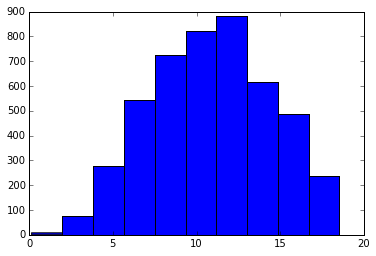

In [69]:
plt.hist(score)
plt.show()

To accept only N-grams with a PMI over 2, for example, we could do (selecting only the last 20):

In [91]:
selected_ngrams = [ngram for ngram in finder.above_score(bigram_measures.pmi, 2.0)]
selected_ngrams[-20:]

[((u'cell', 'NN'), (u'formation', 'NN')),
 ((u'Medical', 'NNP'), (u'Encyclopedia', 'NNP')),
 ((u'research', 'NN'), (u'position', 'NN')),
 ((u'York', 'NNP'), (u'University', 'NNP')),
 ((u'Life', 'NNP'), (u'Science', 'NNP')),
 ((u'year', 'NN'), (u'research', 'NN')),
 ((u'Research', 'NNP'), (u'Society', 'NNP')),
 ((u'system', 'NN'), (u'development', 'NN')),
 ((u'body', 'NN'), (u'cell', 'NN')),
 ((u'cell', 'NN'), (u'number', 'NN')),
 ((u'York', 'NNP'), (u'State', 'NNP')),
 ((u'Stem', 'NNP'), (u'cell', 'NN')),
 ((u'embryo', 'NN'), (u'research', 'NN')),
 ((u'brain', 'NN'), (u'cells', 'NNS')),
 ((u'cells', 'NNS'), (u'age', 'NN')),
 ((u'Charles', 'NNP'), (u'University', 'NNP')),
 ((u'Medical', 'NNP'), (u'University', 'NNP')),
 ((u'Biology', 'NNP'), (u'Institute', 'NNP')),
 ((u'fertilization', 'NN'), (u'research', 'NN')),
 ((u'egg', 'NN'), (u'development', 'NN'))]

In [130]:
selected_expressions = [zip(*ngram)[0] for ngram in selected_ngrams]
selected_expressions[:10]

[(u'Agalychnis', u'callidryas'),
 (u'Androulla', u'Economou'),
 (u'Astacus', u'astacus'),
 (u'Cusance', u'Morant'),
 (u'Dieter', u'Sues'),
 (u'Ethically', u'Responsible'),
 (u'Exakten', u'Erblichkeitslehre'),
 (u'Falske', u'Analogier'),
 (u'Hathaitip', u'Sritanaudomchai'),
 (u'Laurel', u'Hollow')]

In [92]:
tokenizer = nltk.MWETokenizer(selected_expressions)

In [110]:
words_over_time = nltk.ConditionalFreqDist([
    (normalize_token(token).replace('_', ' '), metadata[fileid].date)
    for fileid in corpus.fileids()
    for token in tokenizer.tokenize(corpus.words(fileids=[fileid]))
    if filter_token(token) or '_' in token
])

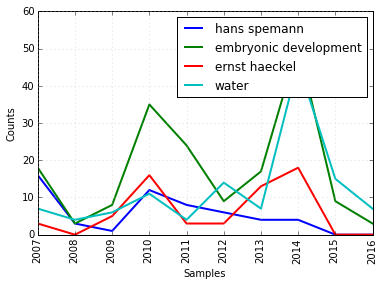

In [128]:
words_over_time.plot(conditions=['hans spemann', 'embryonic development', 'ernst haeckel', 'water'])